### Applying Conv2d

* Key arguments for the Conv2d layer:

  * `in_channels`: Number of channels in the input tensor.
  * `out_channels`: Number of channels in the output tensor (output feature map) after the convolution operation.
  * `kernel_size`: Size of the convolution kernel. Can be a tuple like `(5, 5)` (for a 5x5 kernel) or an integer like `5`.
  * `stride`: Stride of the convolution operation.
  * `padding`: Amount of padding added to the input tensor on all sides before the convolution (used to control the size of the output feature map).


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

input_tensor = torch.randn(3, 28, 28)
print('input tensor shape:', input_tensor.shape)

conv_layer_01 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1) # padding is 0 by default
output_tensor = conv_layer_01(input_tensor)
print('output tensor shape:', output_tensor.shape)

input tensor shape: torch.Size([3, 28, 28])
output tensor shape: torch.Size([8, 24, 24])


In [2]:
conv_layer_01 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=0)

In [3]:
#conv2d layer weight shape
conv_layer_01.weight.shape # 8,3,5,5

torch.Size([8, 3, 5, 5])

In [4]:
input_tensor = torch.randn(3, 28, 28)

# Apply 2 convolution layers, final output shape is (16, 22, 22)
# Output shape of conv_layer_01 = (8, 24, 24)
# With padding='same', output shape would remain (28, 28)
conv_layer_01 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1) # padding='same'
conv_layer_02 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1)
output_01 = conv_layer_01(input_tensor)
output_02 = conv_layer_02(output_01)

print('output_01 shape:', output_01.shape, 'output_02 shape:', output_02.shape)


output_01 shape: torch.Size([8, 24, 24]) output_02 shape: torch.Size([16, 22, 22])


In [5]:
conv_layer_01.weight.shape, conv_layer_02.weight.shape #16 8 3 3

(torch.Size([8, 3, 5, 5]), torch.Size([16, 8, 3, 3]))

### Applying MaxPool2d (AvgPool2d)

* MaxPool2d extracts the maximum value from each window of size `kernel_size` as it moves across the input to produce the output.
* Pooling layers do not have learnable parameters.
* Key purposes:

  * Reduce the size of the input feature map to decrease computational cost.
  * Serve as dimensionality reduction by summarizing key features within each region (`kernel_size`) of the input feature map.
  * Reduce sensitivity to small variations in input, helping to prevent overfitting.
* `kernel_size`, `stride`, and `padding` are parameters for creation. Note that the default value of `stride` is equal to `kernel_size`.


In [6]:
input_tensor = torch.rand(3, 28, 28)
conv_layer_01 = nn.Conv2d(in_channels = 3, out_channels=12, kernel_size=3, stride=1, padding=1)
pool_layer_01 = nn.MaxPool2d(kernel_size=2) #if you don't set stride, it is same as kernerl size
output_01 = conv_layer_01(input_tensor)
output_02 = pool_layer_01(output_01)
print('output_01 shape:', output_01.shape, 'output_02 shape:', output_02.shape)


output_01 shape: torch.Size([12, 28, 28]) output_02 shape: torch.Size([12, 14, 14])


### Creating a CNN-Based Model - 01

* Build a model using Conv2d layers: Conv2d → ReLU → Conv2d → ReLU → MaxPool2d to form the CNN architecture.
* The final classification layer must be a Linear layer, so the 3D feature map output from the Conv2d layers needs to be flattened before connecting to the Linear layer. Apply `Flatten` to the feature map and then connect it to the Linear layer.
* Flattening the final feature map and feeding it to a Linear layer can result in a very large number of learnable parameters in the Linear layer, which may easily lead to overfitting. Dropout or other regularization techniques may be required.
* The `in_features` of the Linear layer must match the number of elements produced by Flatten, which depends on the image size and Conv2d settings. You can calculate it using a formula or determine it in advance with a model summary. However, if the image size or Conv2d configuration changes, it must be recalculated, which can be inconvenient.


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

NUM_INPUT_CHANNELS = 3

# Conv Layer with 3x3 kernel and 32 filters, another Conv Layer with 3x3 kernel and 64 filters, followed by MaxPooling
class SimpleCNN_01(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=NUM_INPUT_CHANNELS, out_channels=32, kernel_size=3, stride=1)
        # Output shape after conv_1: (1, 32, 30, 30)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        # Output shape after conv_2: (1, 64, 28, 28)
        self.pool = nn.MaxPool2d(kernel_size=2)
        # Output shape after pooling: (1, 64, 14, 14)
        self.flatten = nn.Flatten(start_dim=1) 
        # Linear classifier. in_features must match the flattened feature map size (64*14*14)
        # If image size changes, this needs to be recalculated.
        self.classifier = nn.Linear(in_features=64*14*14, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.classifier(x)

        return x

# Example input tensor with batch size 1, 3 channels, 32x32 image
# If image size is changed to 64x64, the classification layer will throw an error
input = torch.randn(1, 3, 32, 32) 
simple_cnn_01 = SimpleCNN_01(num_classes=10)
output = simple_cnn_01(input)
print(output.shape)


torch.Size([1, 10])


In [8]:
from torchinfo import summary

summary(model=simple_cnn_01, input_size=(1, 3, 32, 32),
        col_names=['input_size', 'output_size', 'num_params'],
        row_settings=['var_names'])


Layer (type (var_name))                  Input Shape               Output Shape              Param #
SimpleCNN_01 (SimpleCNN_01)              [1, 3, 32, 32]            [1, 10]                   --
├─Conv2d (conv_1)                        [1, 3, 32, 32]            [1, 32, 30, 30]           896
├─Conv2d (conv_2)                        [1, 32, 30, 30]           [1, 64, 28, 28]           18,496
├─MaxPool2d (pool)                       [1, 64, 28, 28]           [1, 64, 14, 14]           --
├─Flatten (flatten)                      [1, 64, 14, 14]           [1, 12544]                --
├─Linear (classifier)                    [1, 12544]                [1, 10]                   125,450
Total params: 144,842
Trainable params: 144,842
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 15.43
Input size (MB): 0.01
Forward/backward pass size (MB): 0.63
Params size (MB): 0.58
Estimated Total Size (MB): 1.22

### Global Average Pooling using `AdaptiveAvgPool2d`

* In PyTorch, Global Average Pooling (GAP) can be implemented using `nn.AdaptiveAvgPool2d()`.
* `AdaptiveAvgPool2d` takes `output_size` as an argument, and automatically adjusts the pooling region for each input feature map channel so that the output for each channel has the specified size.
* This is particularly useful in CNNs because it allows you to reduce a variable-sized feature map to a fixed-size tensor, making it compatible with subsequent fully connected layers without manually calculating the flattened size.
* For example, setting `output_size=(1,1)` performs global average pooling across the spatial dimensions, resulting in a tensor of shape `(batch_size, channels, 1, 1)`, which can then be flattened for classification.

In [9]:
input = torch.randn(1, 64, 8, 9)

# ouput size is 5x5 by channel
m = nn.AdaptiveAvgPool2d(output_size=(5, 5))
output = m(input)
print(output.shape)

m = nn.AdaptiveAvgPool2d(output_size=(1, 1))
output = m(input)
print(output.shape)


torch.Size([1, 64, 5, 5])
torch.Size([1, 64, 1, 1])


### CNN-based Model Creation - 02

* Instead of flattening the feature map directly, apply Adaptive Global Pooling first, then flatten.
* Unlike `MaxPool2d`, global pooling reduces each channel of the feature map to a single value. Typically, `AdaptiveAvgPool2d` is used.
* Applying `AdaptiveAvgPool2d(output_size=(1, 1))` to the final feature map keeps the number of channels the same but pools the spatial dimensions (height and width) to 1. Therefore, knowing the `out_channels` of the last `Conv2d` layer is sufficient to determine the flattened dimension, which can be used as the `in_features` for the linear layer.
* Global pooling compresses the feature map, significantly reducing the number of parameters in the classification layer.
* Global pooling is generally applied after the CNN has a sufficient depth; otherwise, applying it too early may degrade performance.


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

NUM_INPUT_CHANNELS = 3

class SimpleCNN_02(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=NUM_INPUT_CHANNELS, out_channels=32, kernel_size=3, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.adapt_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
                
        
        self.classifier = nn.Linear(in_features=64, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.pool(x)

        # Global Pooling 적용. 
        x = self.adapt_pool(x)
        x = x.view(x.size(0), -1) #x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)

        return x
        
input = torch.randn(1, 3, 64, 64) 
simple_cnn_02 = SimpleCNN_02(num_classes=10)
output = simple_cnn_02(input)
print(output.shape)

torch.Size([1, 10])


In [11]:
simple_cnn_02 = SimpleCNN_02(num_classes=10)
summary(model=simple_cnn_02, input_size=(1, 3, 64, 64),  
        col_names=['input_size', 'output_size', 'num_params'], 
        row_settings=['var_names'])

Layer (type (var_name))                  Input Shape               Output Shape              Param #
SimpleCNN_02 (SimpleCNN_02)              [1, 3, 64, 64]            [1, 10]                   --
├─Conv2d (conv_1)                        [1, 3, 64, 64]            [1, 32, 62, 62]           896
├─Conv2d (conv_2)                        [1, 32, 62, 62]           [1, 64, 60, 60]           18,496
├─MaxPool2d (pool)                       [1, 64, 60, 60]           [1, 64, 30, 30]           --
├─AdaptiveAvgPool2d (adapt_pool)         [1, 64, 30, 30]           [1, 64, 1, 1]             --
├─Linear (classifier)                    [1, 64]                   [1, 10]                   650
Total params: 20,042
Trainable params: 20,042
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 70.03
Input size (MB): 0.05
Forward/backward pass size (MB): 2.83
Params size (MB): 0.08
Estimated Total Size (MB): 2.96

In [12]:
import torchvision.models as models

# Check how Global Average Pooling is applied in the architecture of torchvision's pretrained models
#model = models.vgg19() #
model = models.resnet50()
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Creating the CIFAR10 Dataset

* Use `torchvision.datasets.CIFAR10` to create the dataset. When `transform=ToTensor()` is applied, the PIL image is converted into a tensor and normalized to values between 0 and 1.
* The `data` attribute of the CIFAR10 dataset contains image values in NumPy array format. The `targets` attribute holds the target labels as `np.uint8`. The `classes` attribute stores the class names mapped to each target.
* Create a DataLoader based on the CIFAR10 dataset.


In [13]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# Out of the total 60,000 data samples, 50,000 are used for training.  
# The training set is further split into training and validation sets.  
# The remaining 10,000 samples are used for testing.  
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
test_dataset =CIFAR10(root='./data', train=False, download=True, transform=ToTensor())

tr_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - tr_size
tr_dataset, val_dataset = random_split(train_dataset, [tr_size, val_size])
print('tr:', len(tr_dataset), 'valid:', len(val_dataset))

tr_loader = DataLoader(tr_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

100%|██████████| 170M/170M [00:11<00:00, 14.9MB/s]


tr: 42500 valid: 7500


In [14]:
images, labels = next(iter(tr_loader))

print(images.shape, labels.shape)
print(images[0].max(), images[0].min(), labels.min(), labels.max())

torch.Size([32, 3, 32, 32]) torch.Size([32])
tensor(0.9647) tensor(0.0392) tensor(0) tensor(9)


In [15]:
# tr_dataset is Subset
print(type(tr_dataset), '\n', type(train_dataset))
print(tr_dataset, '\n', train_dataset)

<class 'torch.utils.data.dataset.Subset'> 
 <class 'torchvision.datasets.cifar.CIFAR10'>
 Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [16]:
# targets contain values from 0 to 9 representing the 10 target classes.  
# classes provide the label names mapped to each target value from 0 to 9.  
# tr_dataset is a subset, so it does not have the .classes attribute.  
# You can check class names using train_dataset.classes.  
print(train_dataset.classes)


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [17]:
train_dataset.data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [18]:
# train_dataset[0] is transformed with ToTensor() every time it is called.  
# For image visualization, a PIL image or a NumPy array is required.  
# train_dataset.data stores images in the form of a NumPy array (channel last).  
print(type(train_dataset.data), train_dataset.data.shape)


<class 'numpy.ndarray'> (50000, 32, 32, 3)


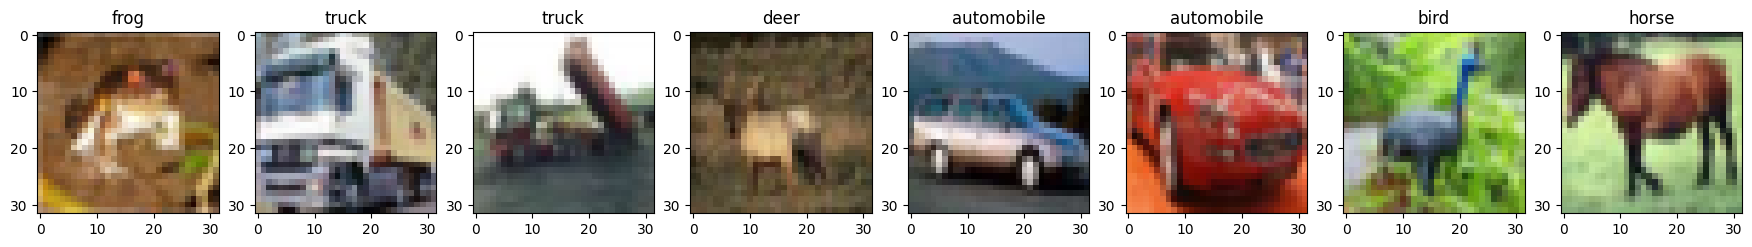

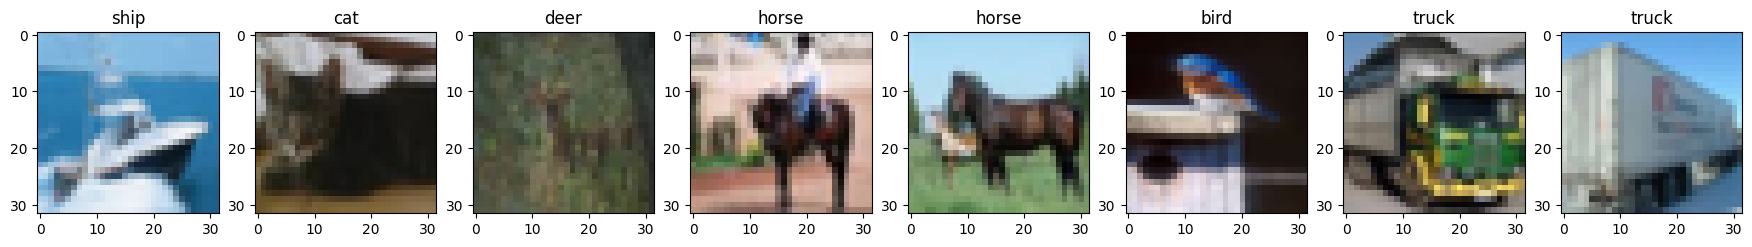

In [19]:
import matplotlib.pyplot as plt

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def show_images(images, labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        # imshow() can directly visualize a NumPy array as an image.
        axs[i].imshow(images[i])
        axs[i].set_title(class_names[labels[i]])
        
show_images(train_dataset.data[:8], train_dataset.targets[:8], ncols=8)
show_images(train_dataset.data[8:16], train_dataset.targets[8:16], ncols=8)


### Building a CNN-based Model - 03

* Increase the number of filters and the depth of the network.
* Sequentially perform conv → relu → conv → relu → pooling.
* Kernel size is 3, and the number of filters increases by block: 32 → 64 → 128.


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

NUM_INPUT_CHANNELS = 3

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Apply conv with padding=1 to keep the output spatial size the same as the input.
        # Kernel size = 3, 32 filters applied consecutively.
        self.conv_11 = nn.Conv2d(in_channels=NUM_INPUT_CHANNELS, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_12 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool_01 = nn.MaxPool2d(kernel_size=2)
        
        # Apply two consecutive Conv2d layers with out_channels=64.
        # stride=1 is default, padding='same' was introduced in version 1.8.
        self.conv_21 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.conv_22 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same')
        self.pool_02 = nn.MaxPool2d(kernel_size=2)

        # Build Conv Layers using Sequential module. 
        # In this case, add ReLU layers explicitly for activation.
        # Apply two Conv layers with 128 filters followed by Max Pooling.
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
       
        # GAP and final Classifier Layer
        self.adapt_pool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.classifier = nn.Linear(in_features=128, out_features=num_classes)

        self.classifier_block = nn.Sequential(
            nn.AdaptiveAvgPool2d(output_size=(1,1)),
            nn.Flatten(),
            nn.Linear(in_features=128, out_features=num_classes)
        )
        
    def forward(self, x):
        x = F.relu(self.conv_11(x))
        x = F.relu(self.conv_12(x))
        x = self.pool_01(x)

        # Alternatively, we could write x = F.max_pool2d(x, 2),
        # but it won’t show up in the summary, so we defined it as a layer instead. 
        
        x = F.relu(self.conv_21(x))
        x = F.relu(self.conv_22(x))
        x = self.pool_02(x)

        x = self.conv_block(x)
        # global pooling 
        # x = self.adapt_pool(x)
        # x = torch.flatten(x, start_dim=1)
        # or x = x.view(x.size(0), -1)
        # final classification
        # x = self.classifier(x)
        # Or, forward through classifier_block as shown below
        x = self.classifier_block(x)
        return x


simple_cnn = SimpleCNN(num_classes=10)

summary(model=simple_cnn, input_size=(1, 3, 32, 32), 
        col_names=['input_size', 'output_size', 'num_params'], 
        row_settings=['var_names'])


Layer (type (var_name))                  Input Shape               Output Shape              Param #
SimpleCNN (SimpleCNN)                    [1, 3, 32, 32]            [1, 10]                   1,290
├─Conv2d (conv_11)                       [1, 3, 32, 32]            [1, 32, 32, 32]           896
├─Conv2d (conv_12)                       [1, 32, 32, 32]           [1, 32, 32, 32]           9,248
├─MaxPool2d (pool_01)                    [1, 32, 32, 32]           [1, 32, 16, 16]           --
├─Conv2d (conv_21)                       [1, 32, 16, 16]           [1, 64, 16, 16]           18,496
├─Conv2d (conv_22)                       [1, 64, 16, 16]           [1, 64, 16, 16]           36,928
├─MaxPool2d (pool_02)                    [1, 64, 16, 16]           [1, 64, 8, 8]             --
├─Sequential (conv_block)                [1, 64, 8, 8]             [1, 128, 4, 4]            --
│    └─Conv2d (0)                        [1, 64, 8, 8]             [1, 128, 8, 8]            73,856
│    └─ReLU (1) 

In [21]:
from tqdm import tqdm
import torch.nn.functional as F

class Trainer:
    def __init__(self, model, loss_fn, optimizer, train_loader, val_loader, device=None):
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
    
    def train_epoch(self, epoch):
        self.model.train()
        
        # Initialize running average loss
        accu_loss = 0.0
        running_avg_loss = 0.0
        # Initialize accuracy tracking: total samples and correctly predicted samples
        num_total = 0.0
        accu_num_correct = 0.0
        accuracy = 0.0
        
        # Use tqdm to visualize training loop progress
        with tqdm(total=len(self.train_loader), desc=f"Epoch {epoch+1} [Training..]", leave=True) as progress_bar:
            for batch_idx, (inputs, targets) in enumerate(self.train_loader):
                # Move inputs and targets to device (do not use to(device) directly)
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                # Forward pass
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, targets)
                
                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                # Update running average loss
                accu_loss += loss.item()
                running_avg_loss = accu_loss /(batch_idx + 1)

                # Compute accuracy metric
                # Count the number of correct predictions in this batch
                num_correct = (outputs.argmax(-1) == targets).sum().item()
                # Update total and correct counts to calculate running accuracy
                num_total += inputs.shape[0]
                accu_num_correct += num_correct
                accuracy = accu_num_correct / num_total

                # Update tqdm progress bar with running loss and accuracy
                progress_bar.update(1)
                if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:  # Update every 20 batches or last batch
                    progress_bar.set_postfix({"Loss": running_avg_loss, 
                                              "Accuracy": accuracy})
        
        return running_avg_loss, accuracy
                
    def validate_epoch(self, epoch):
        if not self.val_loader:
            return None
            
        self.model.eval()

        # Initialize running average loss
        accu_loss = 0
        running_avg_loss = 0
        # Initialize accuracy tracking: total samples and correctly predicted samples
        num_total = 0.0
        accu_num_correct = 0.0
        accuracy = 0.0
        with tqdm(total=len(self.val_loader), desc=f"Epoch {epoch+1} [Validating]", leave=True) as progress_bar:
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(self.val_loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    
                    outputs = self.model(inputs)
                    
                    loss = self.loss_fn(outputs, targets)
                    # Update running average loss
                    accu_loss += loss.item()
                    running_avg_loss = accu_loss /(batch_idx + 1)

                    # Compute accuracy metric
                    num_correct = (outputs.argmax(-1) == targets).sum().item()
                    # Update total and correct counts to calculate running accuracy
                    num_total += inputs.shape[0]
                    accu_num_correct += num_correct
                    accuracy = accu_num_correct / num_total

                    # Update tqdm progress bar with running loss and accuracy
                    progress_bar.update(1)
                    if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:  # Update every 20 batches or last batch
                        progress_bar.set_postfix({"Loss": running_avg_loss, 
                                                  "Accuracy":accuracy})
        return running_avg_loss, accuracy
    
    def fit(self, epochs):
        # Create a history dictionary to store train/validation results for each epoch
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc = self.validate_epoch(epoch)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f} Train Accuracy: {train_acc:.4f}",
                  f", Val Loss: {val_loss:.4f} Val Accuracy: {val_acc:.4f}" if val_loss is not None else "")
            # Record train/validation results per epoch
            history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
            
        return history 
    
    # Return the trained model
    def get_trained_model(self):
        return self.model


In [22]:
import torch 
import torch.nn as nn
from torch.optim import SGD, Adam

NUM_INPUT_CHANNELS = 3
NUM_CLASSES = 10

# A new model needs to be created. Using a previously trained model would use its already learned parameters.
model = SimpleCNN(num_classes=NUM_CLASSES)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

trainer = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer, 
        train_loader = tr_loader, val_loader=val_loader, device=device)

# Perform training and evaluation
history = trainer.fit(30)


Epoch 1 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 255.43it/s, Loss=1.42, Accuracy=0.471]


Epoch 1/30, Train Loss: 1.7407 Train Accuracy: 0.3413 , Val Loss: 1.4230 Val Accuracy: 0.4712


Epoch 2 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 243.97it/s, Loss=1.17, Accuracy=0.58]


Epoch 2/30, Train Loss: 1.3114 Train Accuracy: 0.5192 , Val Loss: 1.1733 Val Accuracy: 0.5800


Epoch 3 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 251.85it/s, Loss=1.05, Accuracy=0.624]


Epoch 3/30, Train Loss: 1.0947 Train Accuracy: 0.6069 , Val Loss: 1.0532 Val Accuracy: 0.6240


Epoch 4 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 255.75it/s, Loss=0.913, Accuracy=0.675]


Epoch 4/30, Train Loss: 0.9584 Train Accuracy: 0.6595 , Val Loss: 0.9129 Val Accuracy: 0.6747


Epoch 5 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 252.57it/s, Loss=0.9, Accuracy=0.679]


Epoch 5/30, Train Loss: 0.8521 Train Accuracy: 0.7001 , Val Loss: 0.9001 Val Accuracy: 0.6795


Epoch 6 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 256.16it/s, Loss=0.799, Accuracy=0.723]


Epoch 6/30, Train Loss: 0.7610 Train Accuracy: 0.7318 , Val Loss: 0.7989 Val Accuracy: 0.7227


Epoch 7 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 254.16it/s, Loss=0.806, Accuracy=0.712]


Epoch 7/30, Train Loss: 0.6831 Train Accuracy: 0.7595 , Val Loss: 0.8061 Val Accuracy: 0.7123


Epoch 8 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 261.49it/s, Loss=0.723, Accuracy=0.754]


Epoch 8/30, Train Loss: 0.6152 Train Accuracy: 0.7850 , Val Loss: 0.7233 Val Accuracy: 0.7540


Epoch 9 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 242.10it/s, Loss=0.838, Accuracy=0.717]


Epoch 9/30, Train Loss: 0.5555 Train Accuracy: 0.8046 , Val Loss: 0.8384 Val Accuracy: 0.7172


Epoch 10 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 250.35it/s, Loss=0.765, Accuracy=0.743]


Epoch 10/30, Train Loss: 0.5064 Train Accuracy: 0.8234 , Val Loss: 0.7651 Val Accuracy: 0.7427


Epoch 11 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 261.03it/s, Loss=0.673, Accuracy=0.781]


Epoch 11/30, Train Loss: 0.4611 Train Accuracy: 0.8381 , Val Loss: 0.6727 Val Accuracy: 0.7815


Epoch 12 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 237.10it/s, Loss=0.684, Accuracy=0.781]


Epoch 12/30, Train Loss: 0.4119 Train Accuracy: 0.8567 , Val Loss: 0.6840 Val Accuracy: 0.7809


Epoch 13 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 259.25it/s, Loss=0.748, Accuracy=0.765]


Epoch 13/30, Train Loss: 0.3699 Train Accuracy: 0.8688 , Val Loss: 0.7480 Val Accuracy: 0.7645


Epoch 14 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 250.91it/s, Loss=0.717, Accuracy=0.781]


Epoch 14/30, Train Loss: 0.3297 Train Accuracy: 0.8832 , Val Loss: 0.7171 Val Accuracy: 0.7813


Epoch 15 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 249.47it/s, Loss=0.726, Accuracy=0.784]


Epoch 15/30, Train Loss: 0.2915 Train Accuracy: 0.8956 , Val Loss: 0.7259 Val Accuracy: 0.7841


Epoch 16 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 256.96it/s, Loss=0.813, Accuracy=0.783]


Epoch 16/30, Train Loss: 0.2552 Train Accuracy: 0.9089 , Val Loss: 0.8126 Val Accuracy: 0.7831


Epoch 17 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 257.71it/s, Loss=0.845, Accuracy=0.772]


Epoch 17/30, Train Loss: 0.2302 Train Accuracy: 0.9185 , Val Loss: 0.8447 Val Accuracy: 0.7723


Epoch 18 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 263.08it/s, Loss=0.989, Accuracy=0.766]


Epoch 18/30, Train Loss: 0.2031 Train Accuracy: 0.9282 , Val Loss: 0.9886 Val Accuracy: 0.7663


Epoch 19 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 245.11it/s, Loss=0.993, Accuracy=0.773]


Epoch 19/30, Train Loss: 0.1776 Train Accuracy: 0.9363 , Val Loss: 0.9927 Val Accuracy: 0.7732


Epoch 20 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 256.46it/s, Loss=1.08, Accuracy=0.762]


Epoch 20/30, Train Loss: 0.1640 Train Accuracy: 0.9419 , Val Loss: 1.0794 Val Accuracy: 0.7616


Epoch 21 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 240.36it/s, Loss=1, Accuracy=0.768]


Epoch 21/30, Train Loss: 0.1476 Train Accuracy: 0.9472 , Val Loss: 1.0030 Val Accuracy: 0.7680


Epoch 22 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 251.40it/s, Loss=1.24, Accuracy=0.763]


Epoch 22/30, Train Loss: 0.1414 Train Accuracy: 0.9491 , Val Loss: 1.2410 Val Accuracy: 0.7629


Epoch 23 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 262.96it/s, Loss=1.1, Accuracy=0.768]


Epoch 23/30, Train Loss: 0.1280 Train Accuracy: 0.9553 , Val Loss: 1.0985 Val Accuracy: 0.7677


Epoch 24 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 244.59it/s, Loss=1.25, Accuracy=0.762]


Epoch 24/30, Train Loss: 0.1124 Train Accuracy: 0.9607 , Val Loss: 1.2450 Val Accuracy: 0.7617


Epoch 25 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 249.02it/s, Loss=1.23, Accuracy=0.774]


Epoch 25/30, Train Loss: 0.1182 Train Accuracy: 0.9576 , Val Loss: 1.2284 Val Accuracy: 0.7743


Epoch 26 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 262.64it/s, Loss=1.23, Accuracy=0.768]


Epoch 26/30, Train Loss: 0.1106 Train Accuracy: 0.9605 , Val Loss: 1.2275 Val Accuracy: 0.7684


Epoch 27 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 249.22it/s, Loss=1.28, Accuracy=0.775]


Epoch 27/30, Train Loss: 0.0993 Train Accuracy: 0.9650 , Val Loss: 1.2767 Val Accuracy: 0.7755


Epoch 28 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 258.59it/s, Loss=1.4, Accuracy=0.759]


Epoch 28/30, Train Loss: 0.1096 Train Accuracy: 0.9618 , Val Loss: 1.4038 Val Accuracy: 0.7592


Epoch 29 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 255.98it/s, Loss=1.27, Accuracy=0.774]


Epoch 29/30, Train Loss: 0.1007 Train Accuracy: 0.9639 , Val Loss: 1.2743 Val Accuracy: 0.7743


Epoch 30 [Validating]: 100%|██████████| 235/235 [00:00<00:00, 238.97it/s, Loss=1.43, Accuracy=0.771]

Epoch 30/30, Train Loss: 0.0970 Train Accuracy: 0.9660 , Val Loss: 1.4276 Val Accuracy: 0.7709


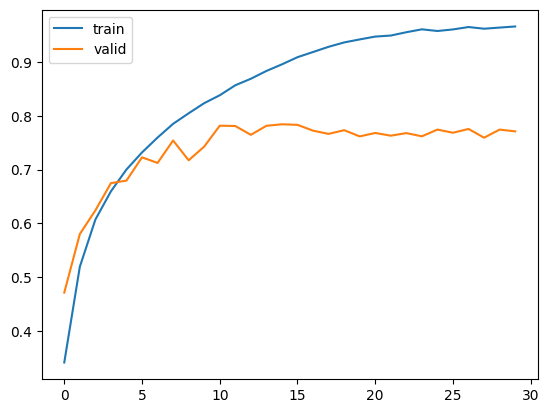

In [23]:
import matplotlib.pyplot as plt

# Visualize
def show_history(history, metric='acc'):
    if metric == 'loss':
        train_metric_name = 'train_loss'
        val_metric_name = 'val_loss'
    else:
        train_metric_name = 'train_acc'
        val_metric_name = 'val_acc'
        
    plt.plot(history[train_metric_name], label='train')
    plt.plot(history[val_metric_name], label='valid')
    plt.legend()
    
show_history(history, metric='acc')

In [24]:
class Predictor:
    def __init__(self, model, device):
        self.model = model.to(device)
        self.device = device

    def evaluate(self, loader):
        self.model.eval()
        eval_metric = 0.0
        
        num_total = 0.0
        accu_num_correct = 0.0

        with tqdm(total=len(loader), desc=f"[Evaluating]", leave=True) as progress_bar:
            with torch.no_grad():
                for batch_idx, (inputs, targets) in enumerate(loader):
                    inputs = inputs.to(self.device)
                    targets = targets.to(self.device)
                    pred = self.model(inputs)
 
                    num_correct = (pred.argmax(-1) == targets).sum().item()
                    num_total += inputs.shape[0]
                    accu_num_correct += num_correct
                    eval_metric = accu_num_correct / num_total

                    progress_bar.update(1)
                    if batch_idx % 20 == 0 or (batch_idx + 1) == progress_bar.total:
                        progress_bar.set_postfix({"Accuracy": eval_metric})
        
        return eval_metric

    def predict_proba(self, inputs):
        self.model.eval()
        with torch.no_grad():
            inputs = inputs.to(self.device)
            outputs = self.model(inputs)
            #targets = targets.to(self.device)
            pred_proba = F.softmax(outputs, dim=-1) 

        return pred_proba

    def predict(self, inputs):
        pred_proba = self.predict_proba(inputs)
        pred_class = torch.argmax(pred_proba, dim=-1)

        return pred_class

In [25]:
trained_model = trainer.get_trained_model()
 
# test_dataset = CIFAR10(root='./data', train=False, download=True, transform=ToTensor())
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

predictor = Predictor(model=trained_model, device=device)
eval_metric = predictor.evaluate(test_loader)
print(f'test dataset evaluation:{eval_metric:.4f}')

[Evaluating]: 100%|██████████| 313/313 [00:01<00:00, 268.48it/s, Accuracy=0.768]

test dataset evaluation:0.7677


target value: 3


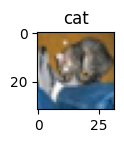

In [26]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(1, 1))
plt.imshow(test_dataset.data[0])
plt.title(class_names[test_dataset.targets[0]])

print('target value:', test_dataset.targets[0])

In [27]:
test_dataset[0]

(tensor([[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
          [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
          [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
          ...,
          [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
          [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
          [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],
 
         [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
          [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
          [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
          ...,
          [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
          [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
          [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],
 
         [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
          [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
          [0.1843, 0.1294, 0.1412,  ...,

In [28]:
test_dataset[0][0].shape

torch.Size([3, 32, 32])

In [29]:
# The image to be predicted must be a tensor with 4 dimensions (batch dimension included). 
# Use unsqueeze(0) to add a batch dimension if needed.

pred_class = predictor.predict(test_dataset[0][0].unsqueeze(0))
print('predicted class:', pred_class.item())

predicted class: 3


### Calculating the Output Feature Map Size
* Compute the size of the output feature map based on the input feature map size, convolution kernel size, stride, and padding.
* Let I be the input feature map size, K the kernel size of the filter, P the padding (integer), and S the stride (integer).
* The output size O is calculated as: O = (I - K + 2P)/S + 1


#### Case: Stride = 1 and No Padding, Kernel Size = 3
* Let I be the input feature map size, K the filter's kernel size, P the padding (integer), and S the stride (integer).
* Output size: O = (I - K + 2P)/1 + 1 = (5 - 3 + 0)/1 + 1 = 3


In [30]:
import torch.nn as nn
import torch

input = torch.randn(1, 5, 5)
conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0) #kernel_size=5로 적용
output = conv1(input)
print(output.shape)

torch.Size([16, 3, 3])


#### Stride = 1 Padding = 1
* O = (I - F + 2P)/S + 1 = (5 - 3 + 2 )/1 + 1 = 5

In [31]:
input = torch.randn(1, 5, 5)
conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1) #padding='same'으로 적용 
output = conv1(input)
print(output.shape)

torch.Size([16, 5, 5])


In [32]:
# Zero Padding 
input = torch.randn(1, 5, 5)
padding_layer = nn.ZeroPad2d(padding=1)
padded_input = padding_layer(input)
print('padded input shape:', padded_input.shape)

conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
output = conv1(padded_input)
print(output.shape)

padded input shape: torch.Size([1, 7, 7])
torch.Size([16, 5, 5])


#### Applying Asymmetric Padding
* Conv2d allows specifying padding as a tuple. For example, `padding=(1, 2)` means 1 pixel for top/bottom and 2 pixels for left/right.
* To apply different padding values for top vs bottom or left vs right, use `nn.ZeroPad2d` or the `F.pad()` function.


In [33]:
input = torch.randn(1, 5, 5)
# Conv2d with asymmetric padding: first value for top/bottom, second for left/right
conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=(1, 2)) 
output = conv1(input)  # output shape after conv
print(output.shape)  # prints: torch.Size([16, 7, 9]) (16 channels, height=7, width=9)


torch.Size([16, 5, 7])


In [34]:
# Zero Padding 
input = torch.randn(1, 5, 5)
#padding = (left, right, top, bottom)
padding_layer = nn.ZeroPad2d(padding=(0, 1, 0, 2))
padded_input = padding_layer(input)
print('padded input shape:', padded_input.shape)

conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
output = conv1(padded_input)
print(output.shape)

padded input shape: torch.Size([1, 7, 6])
torch.Size([16, 5, 4])


### Applying Kernel with Stride on 6×6 Input

* Input size `I = 6`, Kernel size `K = 3`, Stride `S = 2`, Padding `P = 0`
* Output size formula: `O = (I - K + 2P)/S + 1 = (6 - 3 + 0)/2 + 1 = 2.5 → 2`
* When using stride > 1, convolution may not fully cover the edges of the input. To avoid losing information at the borders, padding is usually added.


In [35]:
input = torch.randn(1, 6, 6)
conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2) 
output = conv1(input)
print(output.shape)

torch.Size([16, 2, 2])


In [36]:
input = torch.randn(1, 6, 6)
conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=(1, 1)) 
output = conv1(input)
print(output.shape)

torch.Size([16, 3, 3])


### Apply Maxpooling

In [37]:
input = torch.randn(1, 224, 224) # (1, 223, 223)
max_pool = nn.MaxPool2d(kernel_size=2, stride=2) 
output = max_pool(input)
print(output.shape)

torch.Size([1, 112, 112])
